 Task 3: Q-learning for mobile robot navigation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
### auxiliary functions
import pandas as pd


def action_decode(act_code):
    dirs = {0: "N", 1: "E", 2: "S", 3: "W"}
    return dirs[act_code]


def action_encode(act):
    dir_codes = {"N": 0, "E": 1, "S": 2, "W": 3}
    return dir_codes(act)


def display_learning(series, label):
    n_episodes = len(series)
    show_n = 20
    show_step = int(n_episodes / show_n)
    sequence = []
    for i in range(show_n):
        sequence.append(np.mean(series[show_step * i:show_step * (i + 1)]))
        print((i + 1) * show_step, ' episodes ', label, sequence[-1])
    print('\n')
    plt.figure()
    plt.plot(sequence)
    plt.ylabel(label)
    plt.xlabel('episodes')


def update_dataframe(df, result_steps, test_agent_steps, rewards, episodes, maze_height, maze_width, decay, start):
    """
    Update the data frame with a new row of data.
    """
    new_row = pd.DataFrame({'Result Steps': [result_steps],
                            'Test Result Steps': [test_agent_steps],
                            'Rewards': [rewards],
                            'Episodes': [episodes],
                            'Maze Height': [maze_height],
                            'Maze Width': [maze_width],
                            'Decay(Learning Rate)': [decay],
                            'Start': [start]
                            })
    df = pd.concat([df, new_row], ignore_index=True)
    return df

In [2]:
class grid_env():
    ### definition of the maze environment

    def __init__(self, width=5, height=5, start=[0, 0], debug=False):
        # Contructor methods create the environment with some given options
        self.width = width
        self.height = height
        self.start = start
        self.goal = [self.width - 1, self.height - 1]
        self.debug = debug
        self.n_states = self.width * self.height
        self.reset()

    def reset(self):
        # Reset method puts the state at the starting position
        self.pos = self.start[:]  # columns, rows
        return self.pos, 0, False

    def state_decode(self, obs_code):
        r = obs_code // self.width
        c = obs_code % self.width
        return ([c, r])

    def state_encode(self, position):
        code = position[0] + position[1] * (self.width)  # columns, rows
        return (code)

    def step(self, action):
        # Depending on the action, update the environment state
        if action == "S" and (self.pos[1] < self.height - 1):
            self.pos[1] += 1
        elif action == "N" and self.pos[1] > 0:
            self.pos[1] -= 1
        elif action == "W" and self.pos[0] > 0:
            self.pos[0] -= 1
        elif action == "E" and (self.pos[0] < self.width - 1):
            self.pos[0] += 1

        done = (self.pos == self.goal)  # check if goal was reached
        if done:
            reward = self.width + self.height  # reward at goal
        else:
            reward = -1  # negative reward at every step

        if self.debug:
            print(self.render())

        return self.pos, reward, done

    def render(self):
        res = ""
        for y in range(self.height):
            for x in range(self.width):
                if self.goal[0] == x and self.goal[1] == y:
                    if self.pos[0] == x and self.pos[1] == y:
                        res += "@"
                    else:
                        res += "o"
                    continue
                if self.pos[0] == x and self.pos[1] == y:
                    res += "x"
                else:
                    res += "_"
            res += "\n"
        return (res)

In [3]:
class agent():
    ### definition of the agent

    def __init__(self, n_obs, discount=1, learning_rate=0.1, eps={'start': 1, 'min': 0.01, 'decay': 0.001}):
        self.action_space = np.asarray([0, 1, 2, 3])  # north, east, south, west
        n_actions = np.shape(self.action_space)[0]
        self.Q_table = np.zeros((n_obs, n_actions))

        self.epsilon = eps['start']  #initialize the exploration probability to 1
        self.epsilon_decay = eps['decay']  #exploration decreasing decay for exponential decreasing
        self.epsilon_min = eps['min']  # minimum of exploration proba

        self.gamma = discount  #discounted factor
        self.alpha = learning_rate  #learning rate

    def action_selection(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = self.action_space[np.random.randint(0, 3)]  # choose a random action with probability epsilon
        else:
            action = np.argmax(self.Q_table[state, :])  # choose the best action for that state with prob 1-epsilon
        return (action)

    def policy_update(self, action, reward, state, next_state):
        self.Q_table[state, action] = (1 - self.alpha) * self.Q_table[state, action] + self.alpha * (
                reward + self.gamma * max(self.Q_table[next_state, :]))

    def decrease_exploration(self, e):
        self.epsilon = max(self.epsilon_min, np.exp(-self.epsilon_decay * e))

    def test_agent(self, env):
        state, _, done = env.reset()
        steps = 0
        while not done and steps < 100:
            action = ag.action_selection(env.state_encode(state))
            next_state, reward, done = env.step(action_decode(action))
            steps += 1
        print("Number of steps: ", steps)
        return steps

    def train(self, env, n_episodes=1000, max_steps=100):
        all_rewards = []
        all_steps = []
        for e in range(n_episodes):  # iterate over episodes
            state, _, done = env.reset()
            trial_reward = 0
            t = 0
            while not done and t < max_steps:
                action = ag.action_selection(env.state_encode(state))  # step 1: choose an action
                old_state = state[:]
                next_state, reward, done = env.step(action_decode(
                    action))  # steps 2 and 3: The environment runs the chosen action and returns next state and reward
                ag.policy_update(action, reward, env.state_encode(old_state),
                                 env.state_encode(next_state))  # step 4: policy update
                trial_reward += reward
                t += 1
            ag.decrease_exploration(e)
            all_rewards.append(trial_reward)
            all_steps.append(t)
        return (all_rewards, all_steps)

Task 3

A.	Modify the maze, changing size and shape, and different start positions. How many steps does it take to reach the target? Does the performance vary as you expect?

B.	Change the agent learning parameters (e.g. learning rate, discount factor, exploration values). How does performance change in terms of learning speed and ability to reach the target? What happens if exploration is always maximum? And if it decreases very quickly?

C. Optional. Change the reward applied to different types of actions and test the learning performance. Are you able to find values for which learning is even faster? Imagine that there was a hole in the maze: how can you make the agent learn to avoid it?

250  episodes  reward  -55.664
500  episodes  reward  -25.064
750  episodes  reward  -11.304
1000  episodes  reward  -6.36
1250  episodes  reward  -3.612
1500  episodes  reward  -1.776
1750  episodes  reward  -0.284
2000  episodes  reward  0.564
2250  episodes  reward  0.952
2500  episodes  reward  1.432
2750  episodes  reward  1.928
3000  episodes  reward  2.032
3250  episodes  reward  2.368
3500  episodes  reward  2.516
3750  episodes  reward  2.564
4000  episodes  reward  2.684
4250  episodes  reward  2.788
4500  episodes  reward  2.836
4750  episodes  reward  2.832
5000  episodes  reward  2.852


250  episodes  steps  71.708
500  episodes  steps  45.392
750  episodes  steps  32.22
1000  episodes  steps  27.36
1250  episodes  steps  24.612
1500  episodes  steps  22.776
1750  episodes  steps  21.284
2000  episodes  steps  20.436
2250  episodes  steps  20.048
2500  episodes  steps  19.568
2750  episodes  steps  19.072
3000  episodes  steps  18.968
3250  episodes  steps  18.632
3500  e

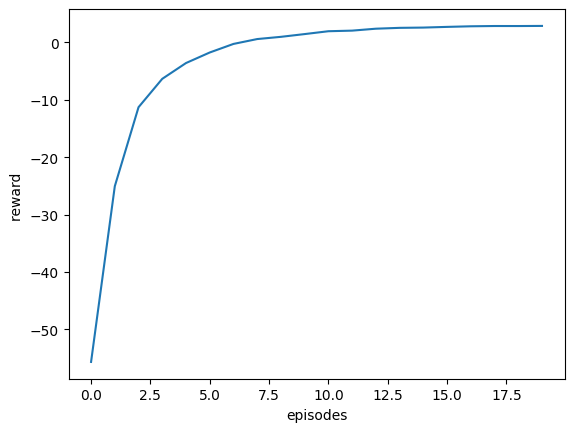

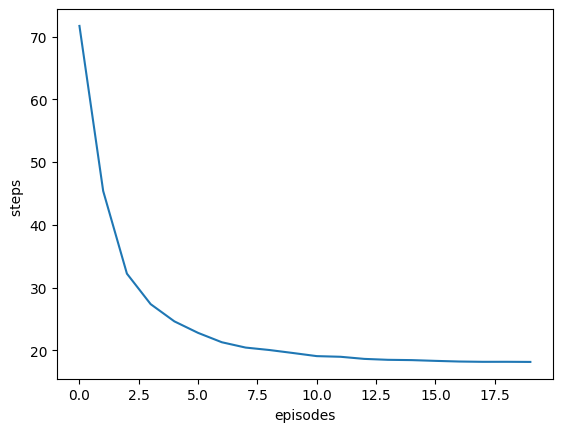

In [4]:
# this code is only an example, remove it or change it

maze_height = 10
maze_width = 10
start = [0, 0]
maze = grid_env(maze_height, maze_width, start)

decay = 0.001
epsilon = {'start': 1, 'min': 0.01, 'decay': decay}  # parameter epsilon needs to be a dictionary
ag = agent(maze.n_states,
           eps=epsilon)  # only one parameter is compulsory, try adding different values of discount factor and learing rate
episodes = 5000
steps = 100
[rewards, steps] = ag.train(maze, episodes, steps)

display_learning(rewards, "reward ")
display_learning(steps, "steps ")

print(ag.Q_table)

maze = grid_env(maze_height, maze_width, start, debug=True)
test_agent_steps = ag.test_agent(maze)
"Number of steps", test_agent_steps

df = pd.DataFrame({'Result Steps': [steps],
                   'Test Result Steps': [test_agent_steps],
                   'Rewards': [rewards],
                   'Episodes': [episodes],
                   'Maze Height': [maze_height],
                   'Maze Width': [maze_width],
                   'Decay(Learning Rate)': [decay],
                   'Start': [start]
                   })


In [6]:
df.describe()

,Test Result Steps,Episodes,Maze Height,Maze Width,Decay(Learning Rate)
count,1.0,1.0,1.0,1.0,1.000
mean,18.0,5000.0,10.0,10.0,0.001
std,NaN,NaN,NaN,NaN,NaN
min,18.0,5000.0,10.0,10.0,0.001
25%,18.0,5000.0,10.0,10.0,0.001
50%,18.0,5000.0,10.0,10.0,0.001
75%,18.0,5000.0,10.0,10.0,0.001
max,18.0,5000.0,10.0,10.0,0.001


250  episodes  reward  -57.3
500  episodes  reward  -24.172
750  episodes  reward  -10.436
1000  episodes  reward  -5.884
1250  episodes  reward  -2.336
1500  episodes  reward  -0.7
1750  episodes  reward  0.132
2000  episodes  reward  0.704
2250  episodes  reward  1.344
2500  episodes  reward  1.7
2750  episodes  reward  2.068
3000  episodes  reward  2.28
3250  episodes  reward  2.508
3500  episodes  reward  2.552
3750  episodes  reward  2.74
4000  episodes  reward  2.756
4250  episodes  reward  2.82
4500  episodes  reward  2.816
4750  episodes  reward  2.876
5000  episodes  reward  2.9


250  episodes  steps  72.084
500  episodes  steps  44.752
750  episodes  steps  31.352
1000  episodes  steps  26.716
1250  episodes  steps  23.336
1500  episodes  steps  21.7
1750  episodes  steps  20.868
2000  episodes  steps  20.296
2250  episodes  steps  19.656
2500  episodes  steps  19.3
2750  episodes  steps  18.932
3000  episodes  steps  18.72
3250  episodes  steps  18.492
3500  episodes  steps

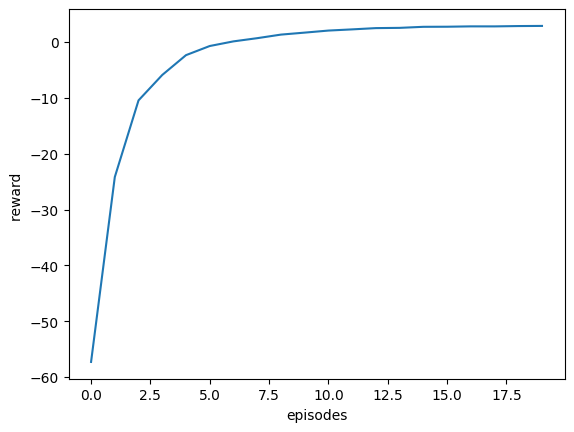

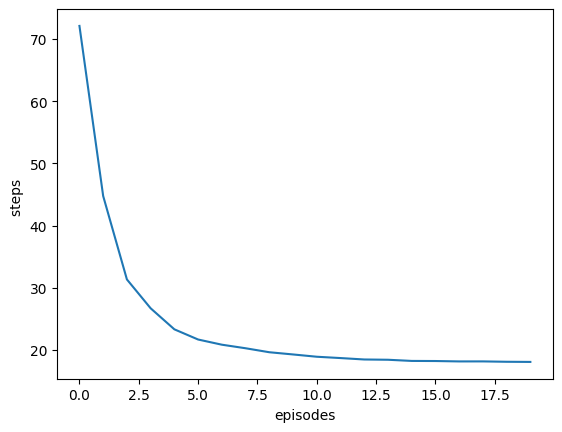

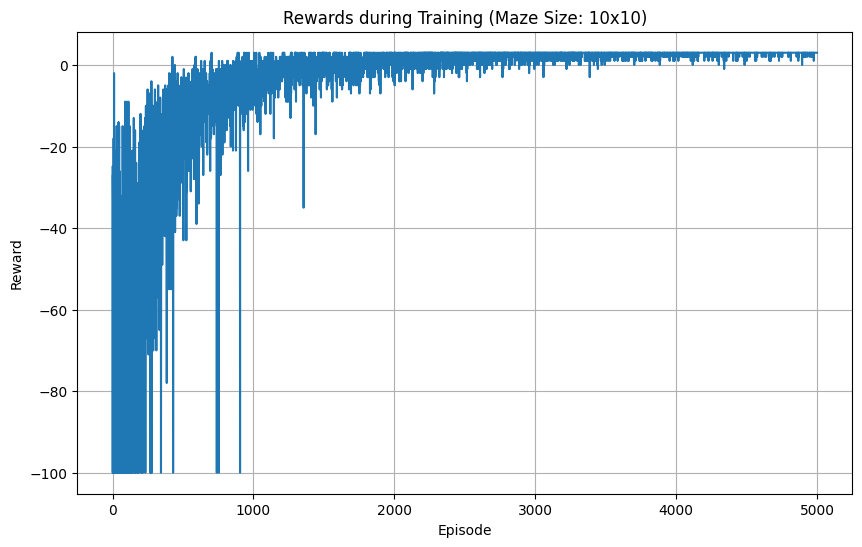

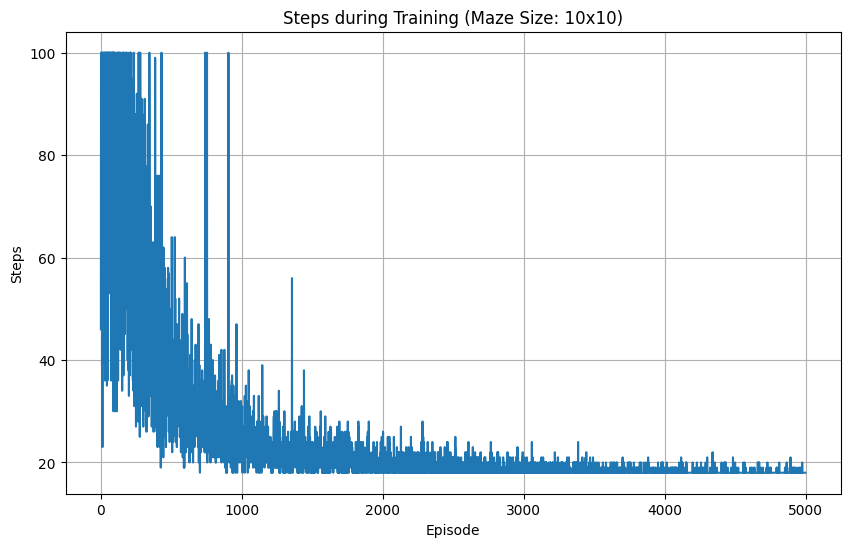

_x________
__________
__________
__________
__________
__________
__________
__________
__________
_________o

__x_______
__________
__________
__________
__________
__________
__________
__________
__________
_________o

___x______
__________
__________
__________
__________
__________
__________
__________
__________
_________o

____x_____
__________
__________
__________
__________
__________
__________
__________
__________
_________o

_____x____
__________
__________
__________
__________
__________
__________
__________
__________
_________o

______x___
__________
__________
__________
__________
__________
__________
__________
__________
_________o

_______x__
__________
__________
__________
__________
__________
__________
__________
__________
_________o

________x_
__________
__________
__________
__________
__________
__________
__________
__________
_________o

_________x
__________
__________
__________
__________
__________
__________
__________
__________
_________o

_

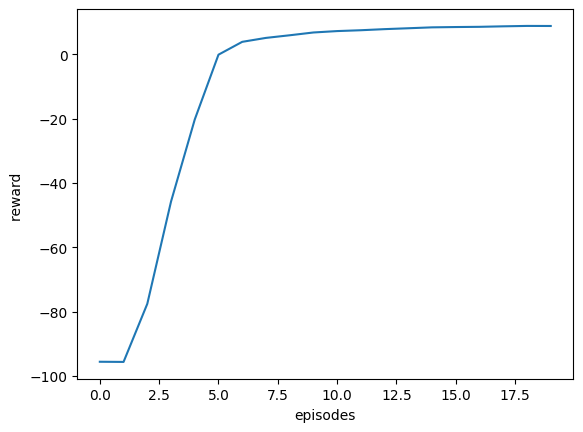

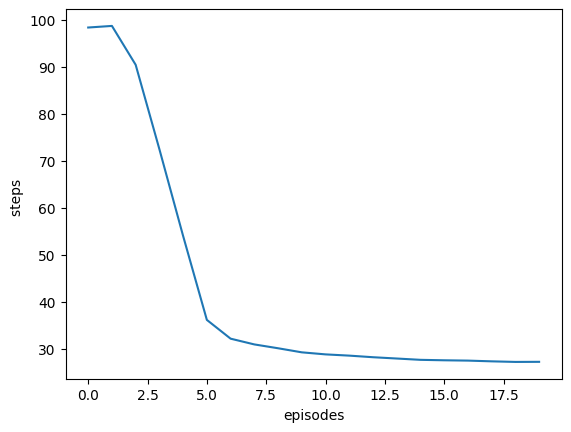

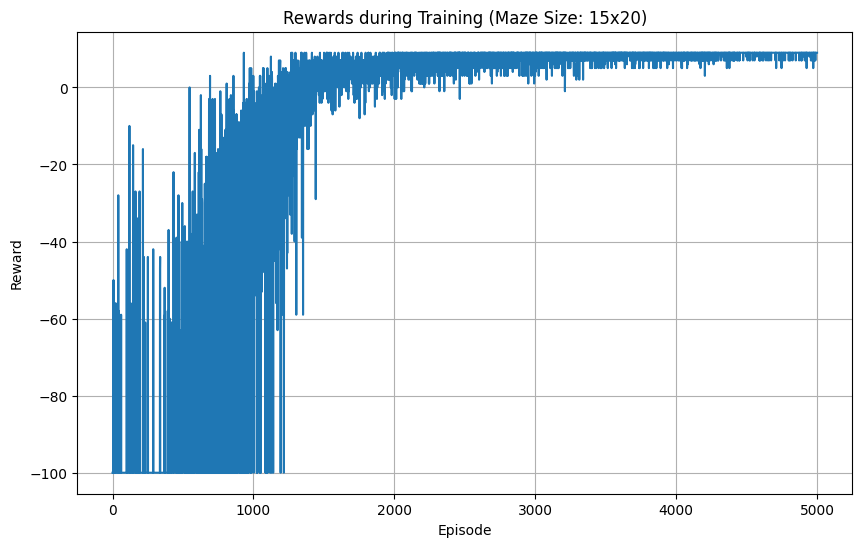

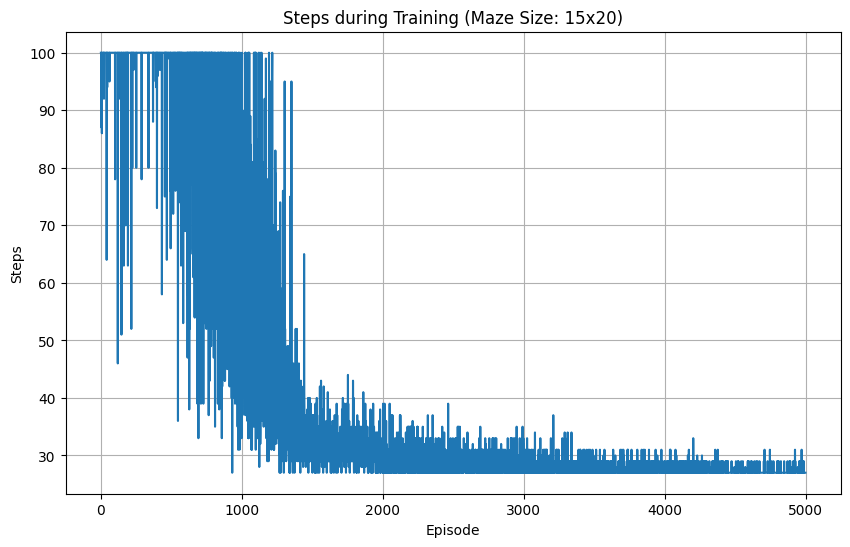

_______________
_______________
_______________
_______________
___x___________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
______________o

_______________
_______________
_______________
_______________
____x__________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
______________o

_______________
_______________
_______________
_______________
_____x_________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
______________o

_______________
_______________
_____

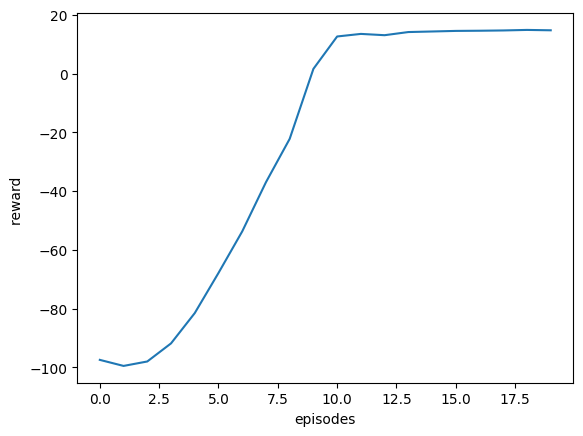

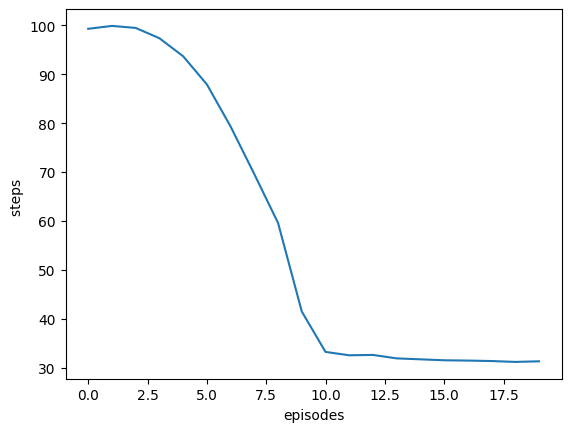

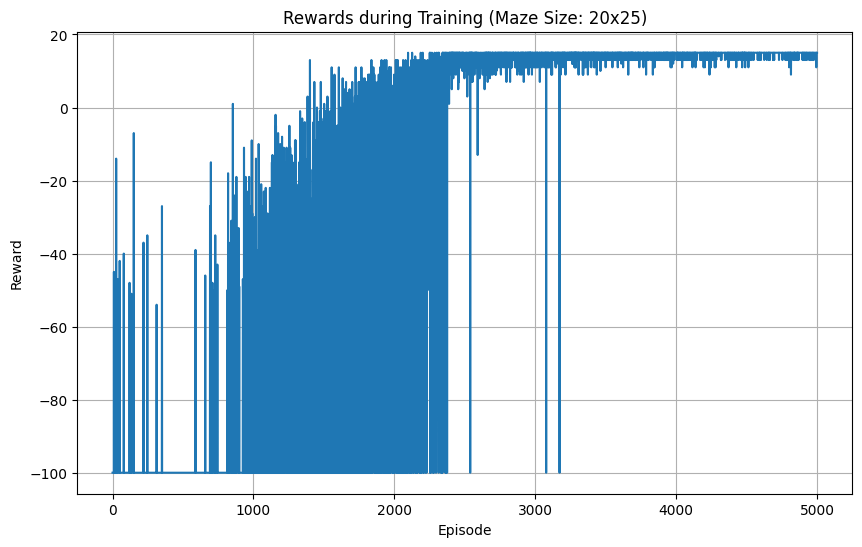

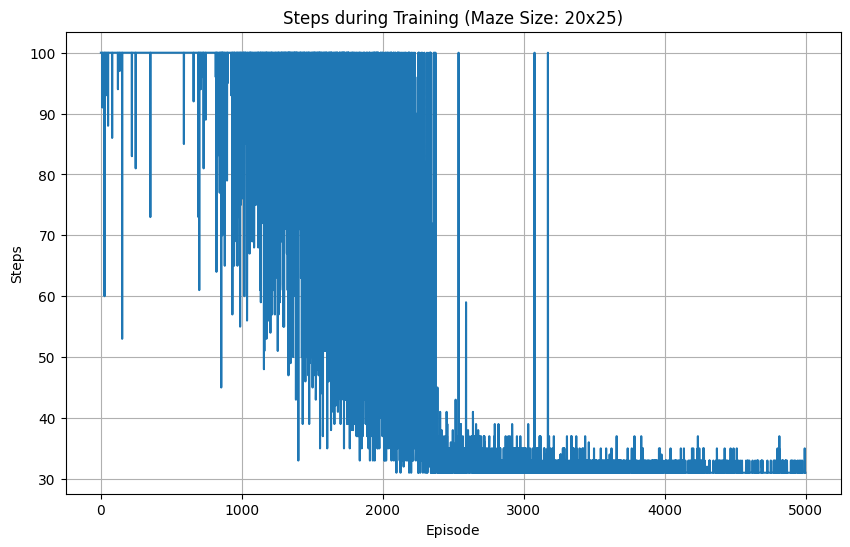

____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
_____x______________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
___________________o

____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
______x_____________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________

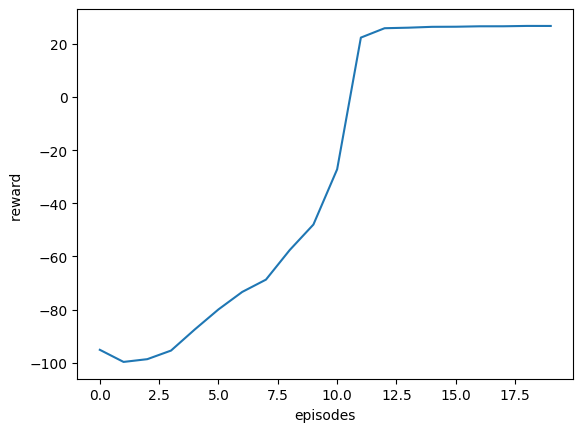

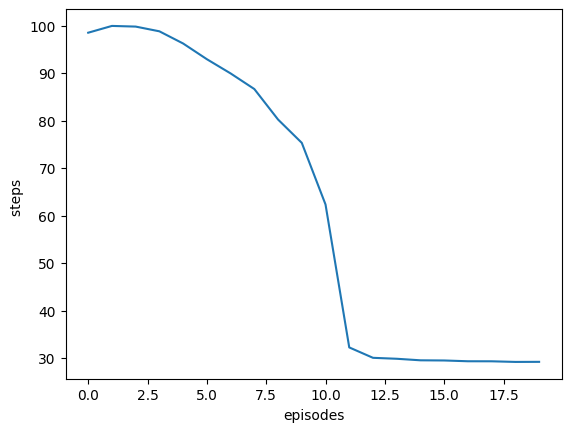

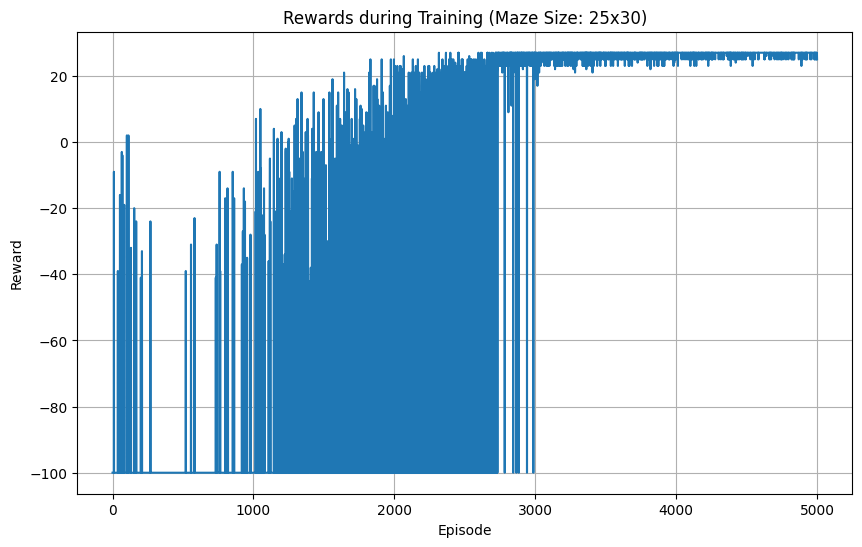

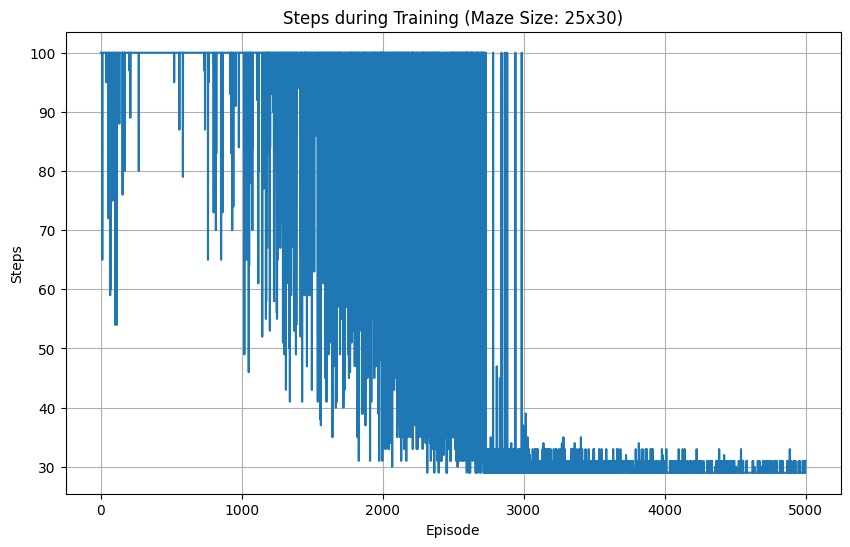

_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________x_______________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
________________________o

_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
___________

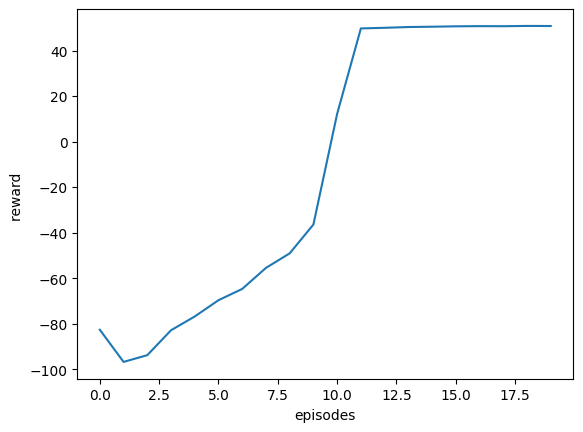

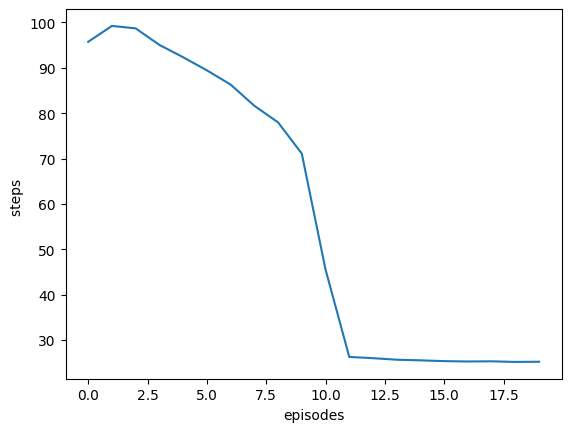

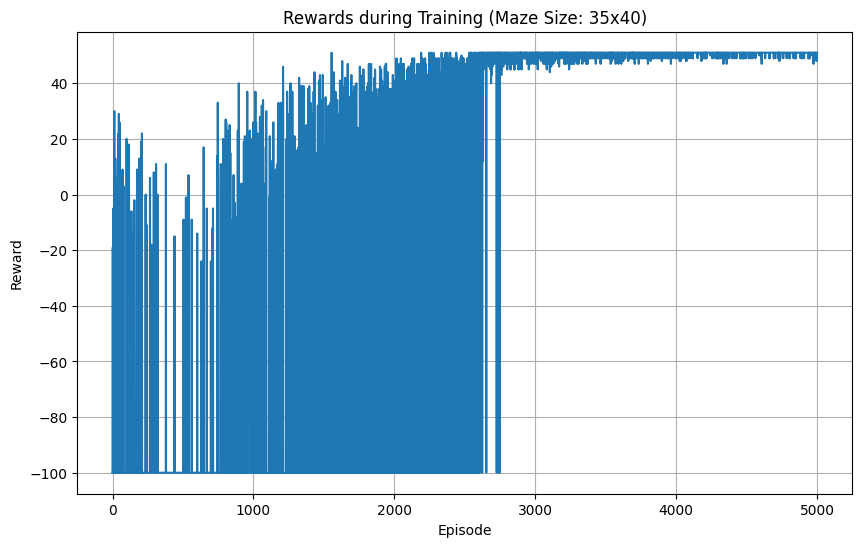

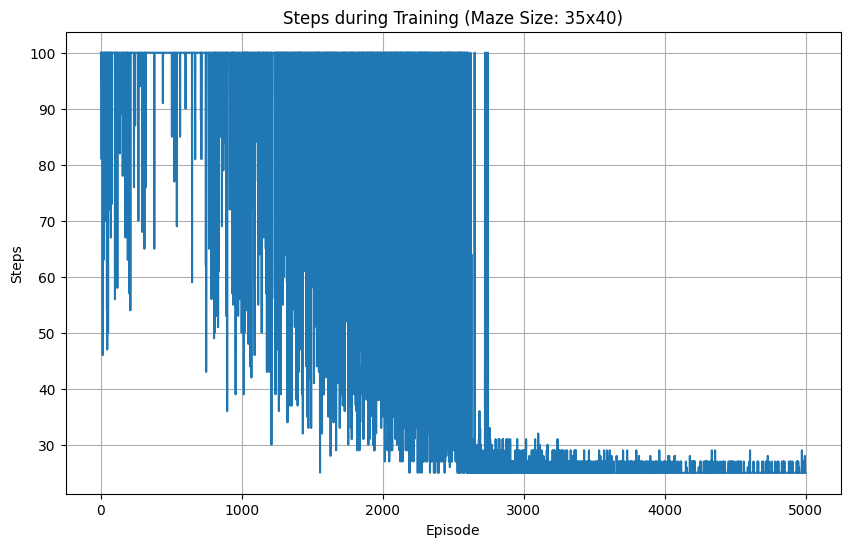

___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
____________________________

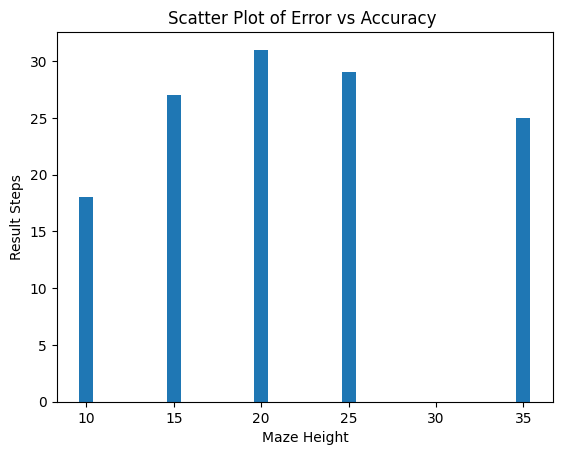

In [8]:

import matplotlib.pyplot as plt

# Define maze parameters
maze_params = [[10, 10], [15, 20], [20, 25], [25, 30], [35, 40]]  # Update maze sizes
start_points = [[0, 0], [2, 4], [4, 8], [8, 16], [16, 32]]  # Update start positions

# Loop through maze parameters
for i in range(len(maze_params)):
    # Create maze environment
    maze_height, maze_width = maze_params[i]
    start = start_points[i]
    maze = grid_env(maze_height, maze_width, start)

    # Create agent
    decay = 0.001

    epsilon = {'start': 1, 'min': 0.01, 'decay': decay}  # Update epsilon values as needed
    ag = agent(maze.n_states, eps=epsilon)  # Update other agent parameters as needed

    # Train agent
    episodes = 5000
    steps = 100
    [rewards, steps] = ag.train(maze, episodes, steps)

    display_learning(rewards, "reward ")
    display_learning(steps, "steps ")

    print(ag.Q_table)

    # Plot rewards and steps
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards during Training (Maze Size: {}x{})'.format(maze_height, maze_width))
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(steps)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.title('Steps during Training (Maze Size: {}x{})'.format(maze_height, maze_width))
    plt.grid(True)
    plt.show()

    # Test agent
    maze = grid_env(maze_height, maze_width, start, debug=True)
    test_agent_steps = ag.test_agent(maze)
    "Number of steps", test_agent_steps

    df = update_dataframe(df, steps, test_agent_steps, rewards, episodes, maze_height, maze_width, decay, start)


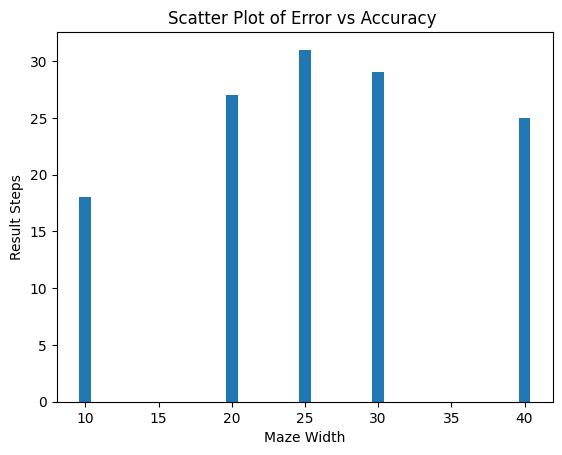

In [9]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Maze Height']
y = df['Test Result Steps']

# Create a scatter plot
plt.bar(x, y)
plt.xlabel('Maze Height')
plt.ylabel('Result Steps')
plt.title('Scatter Plot of Error vs Accuracy ')
plt.show()

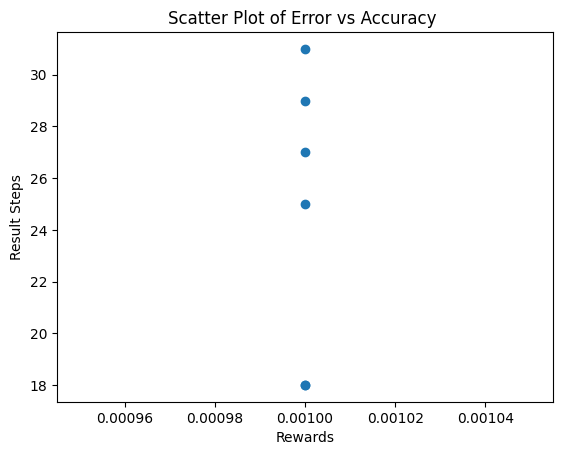

In [13]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Maze Width']
y = df['Test Result Steps']

# Create a scatter plot
plt.bar(x, y)
plt.xlabel('Maze Width')
plt.ylabel('Result Steps')
plt.title('Scatter Plot of Error vs Accuracy ')
plt.show()

250  episodes  reward  -57.568
500  episodes  reward  -27.512
750  episodes  reward  -10.088
1000  episodes  reward  -5.448
1250  episodes  reward  -2.032
1500  episodes  reward  -1.04
1750  episodes  reward  0.18
2000  episodes  reward  1.004
2250  episodes  reward  1.412
2500  episodes  reward  1.724
2750  episodes  reward  2.16
3000  episodes  reward  2.432
3250  episodes  reward  2.404
3500  episodes  reward  2.6
3750  episodes  reward  2.664
4000  episodes  reward  2.72
4250  episodes  reward  2.808
4500  episodes  reward  2.844
4750  episodes  reward  2.912
5000  episodes  reward  2.86


250  episodes  steps  73.192
500  episodes  steps  47.924
750  episodes  steps  31.088
1000  episodes  steps  26.448
1250  episodes  steps  23.032
1500  episodes  steps  22.04
1750  episodes  steps  20.82
2000  episodes  steps  19.996
2250  episodes  steps  19.588
2500  episodes  steps  19.276
2750  episodes  steps  18.84
3000  episodes  steps  18.568
3250  episodes  steps  18.596
3500  episodes 

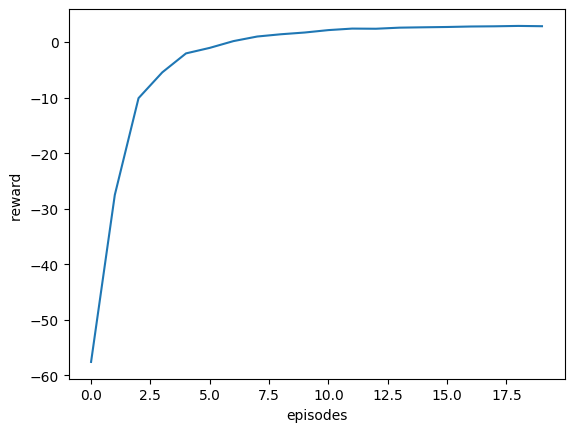

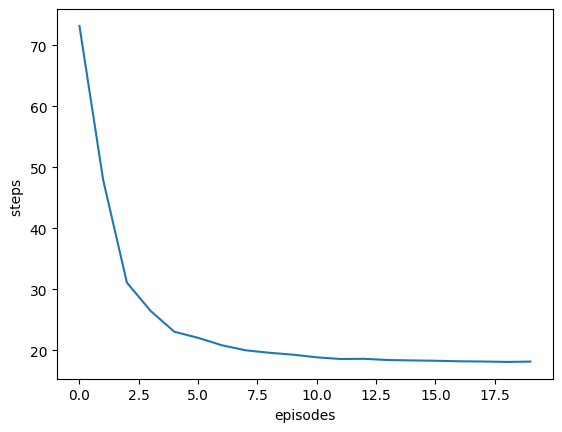

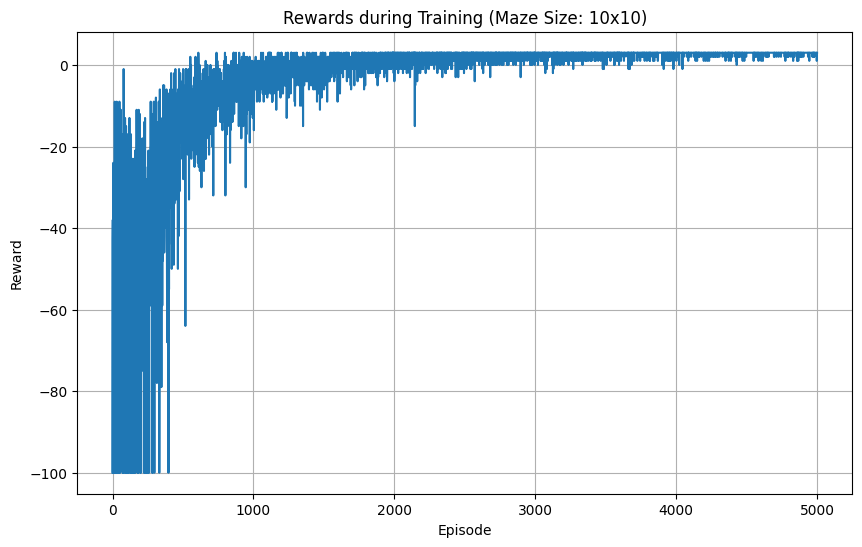

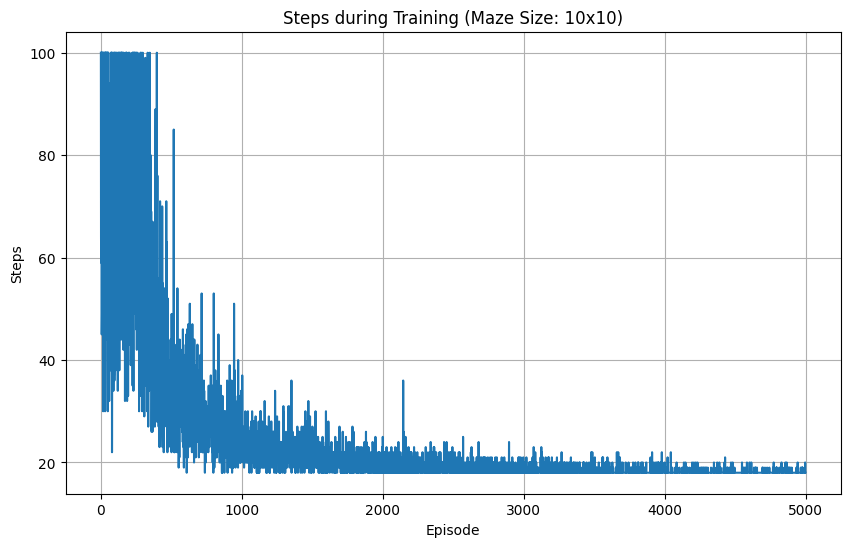

_x________
__________
__________
__________
__________
__________
__________
__________
__________
_________o

__x_______
__________
__________
__________
__________
__________
__________
__________
__________
_________o

___x______
__________
__________
__________
__________
__________
__________
__________
__________
_________o

____x_____
__________
__________
__________
__________
__________
__________
__________
__________
_________o

_____x____
__________
__________
__________
__________
__________
__________
__________
__________
_________o

______x___
__________
__________
__________
__________
__________
__________
__________
__________
_________o

_______x__
__________
__________
__________
__________
__________
__________
__________
__________
_________o

________x_
__________
__________
__________
__________
__________
__________
__________
__________
_________o

_________x
__________
__________
__________
__________
__________
__________
__________
__________
_________o

_

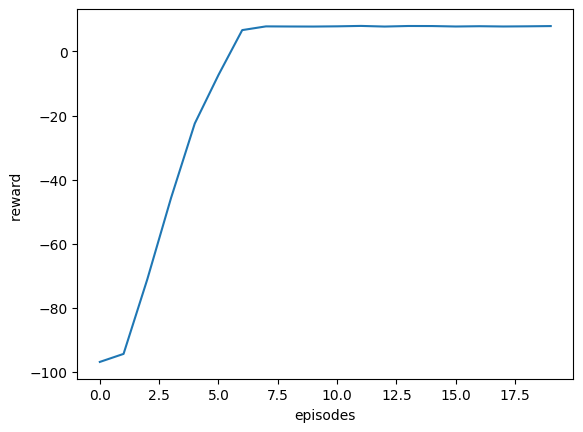

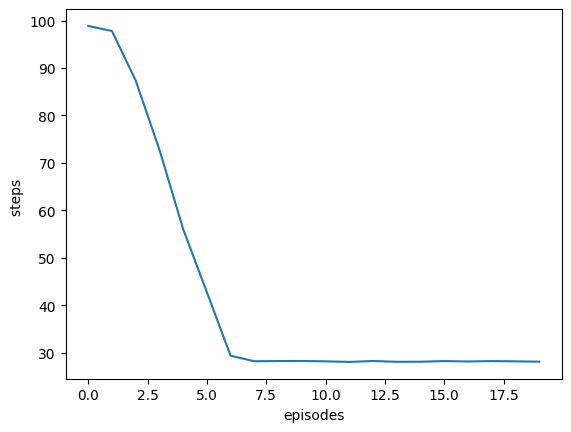

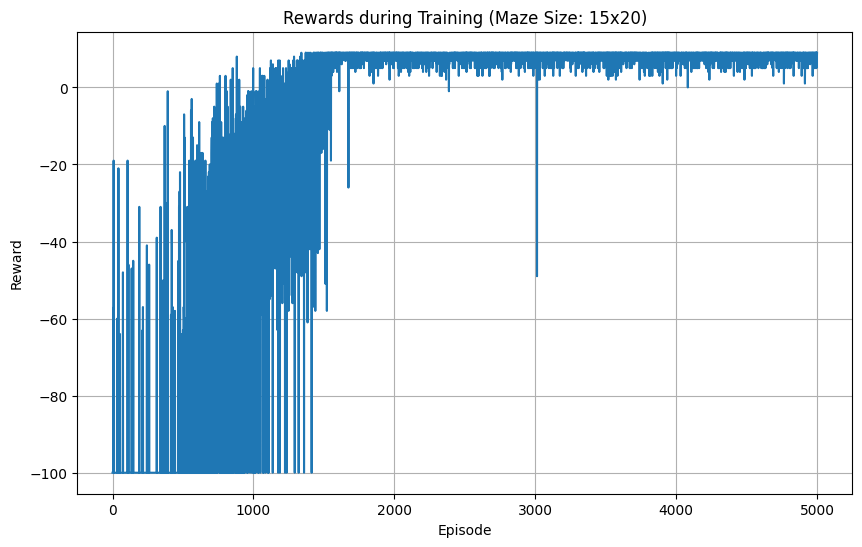

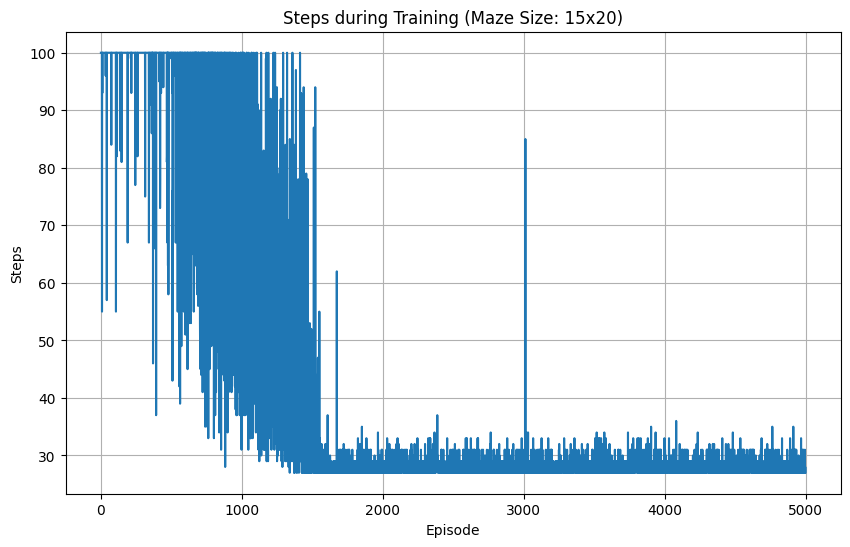

_______________
_______________
_______________
_______________
_______________
__x____________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
______________o

_______________
_______________
_______________
_______________
__x____________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
______________o

_______________
_______________
_______________
_______________
_______________
__x____________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
______________o

_______________
_______________
_____

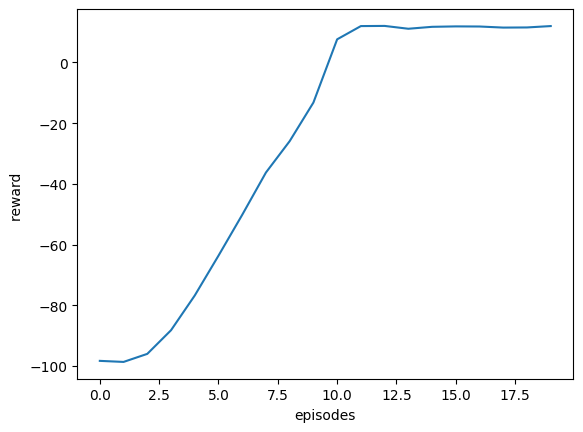

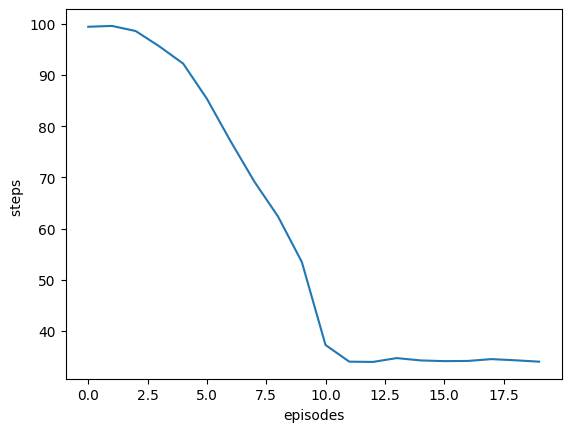

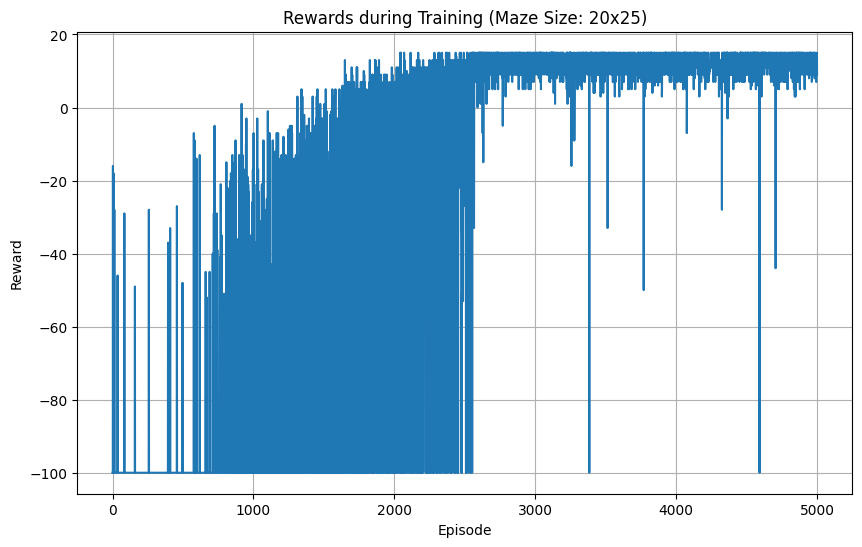

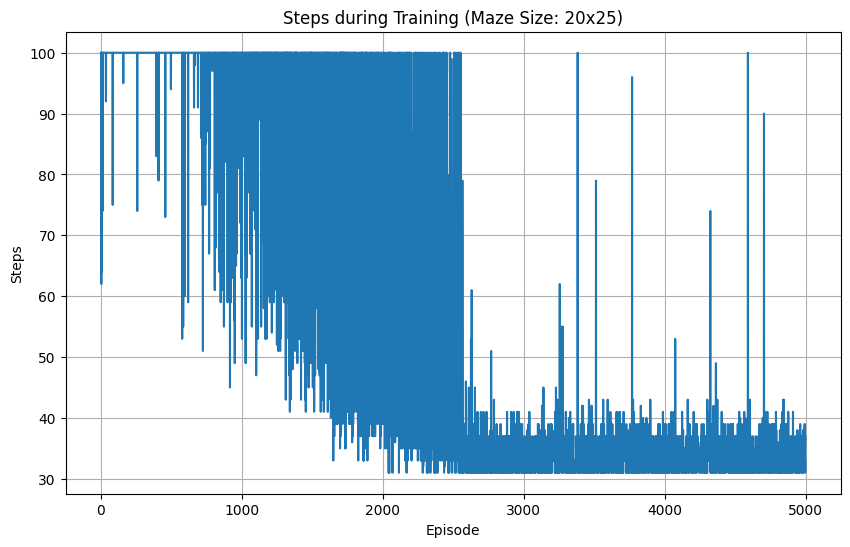

____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
_____x______________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
___________________o

____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
______x_____________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________

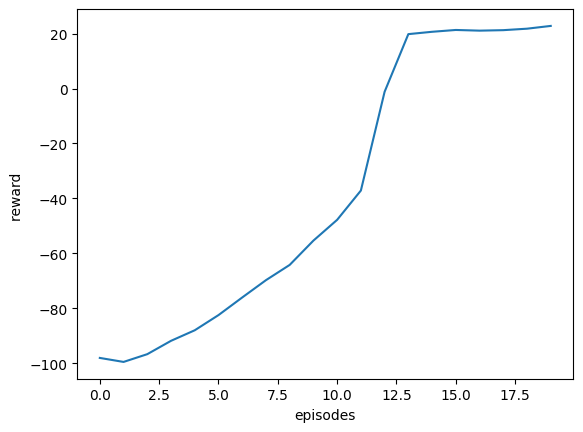

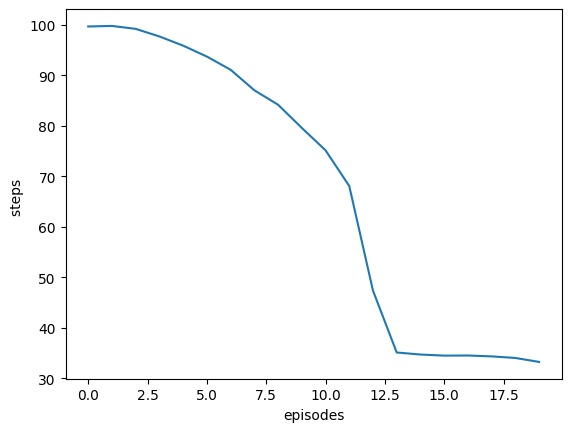

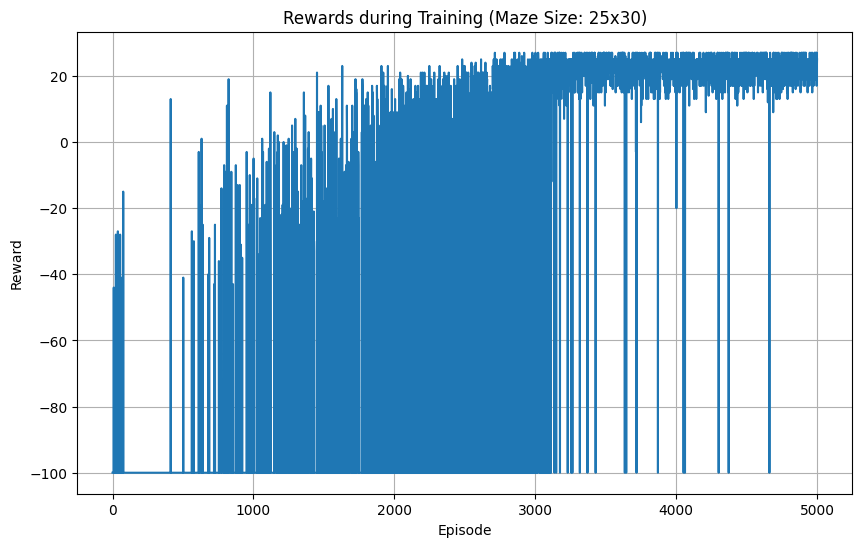

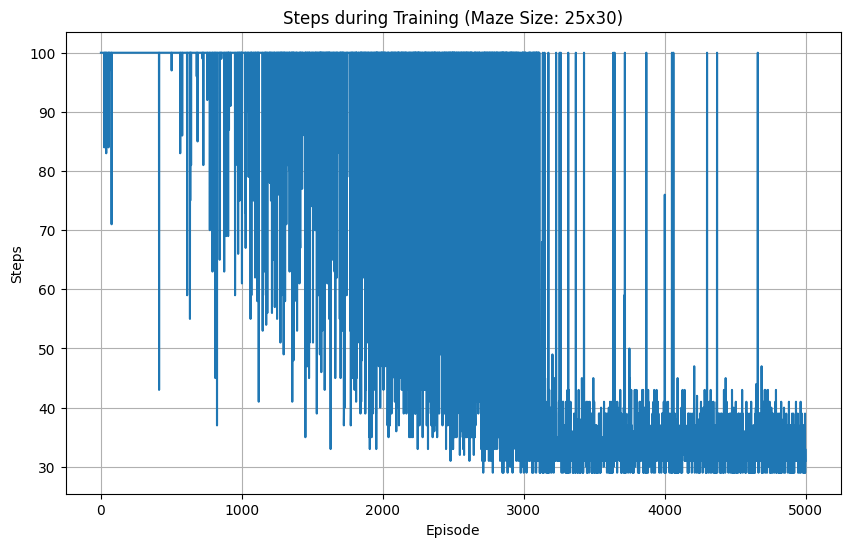

_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________x_______________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
________________________o

_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
___________

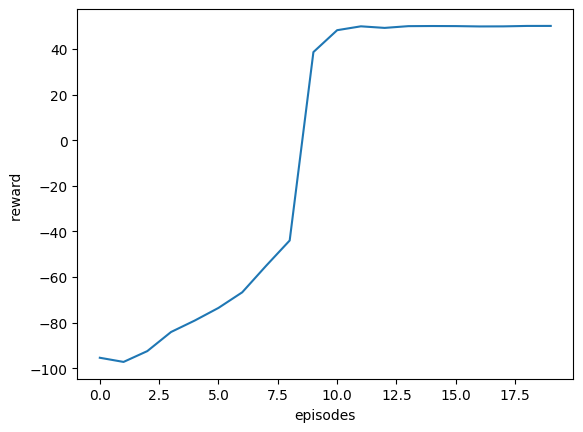

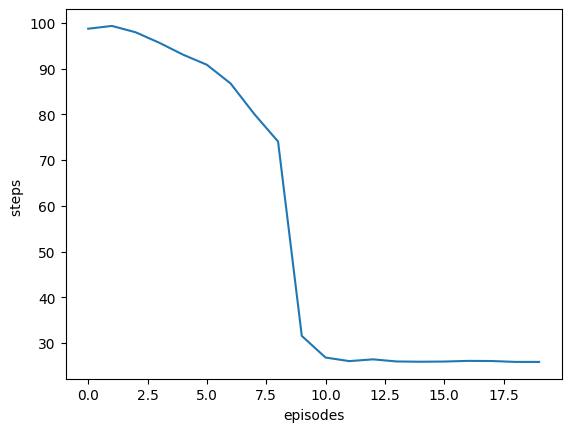

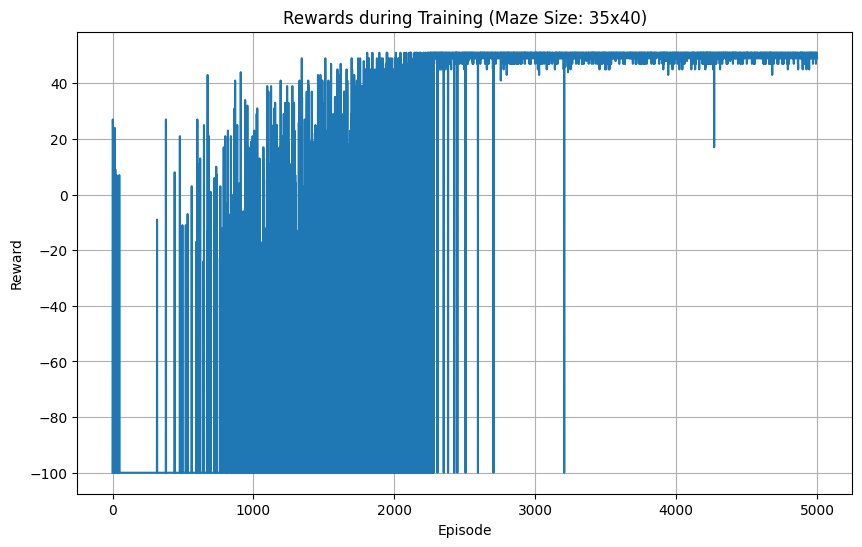

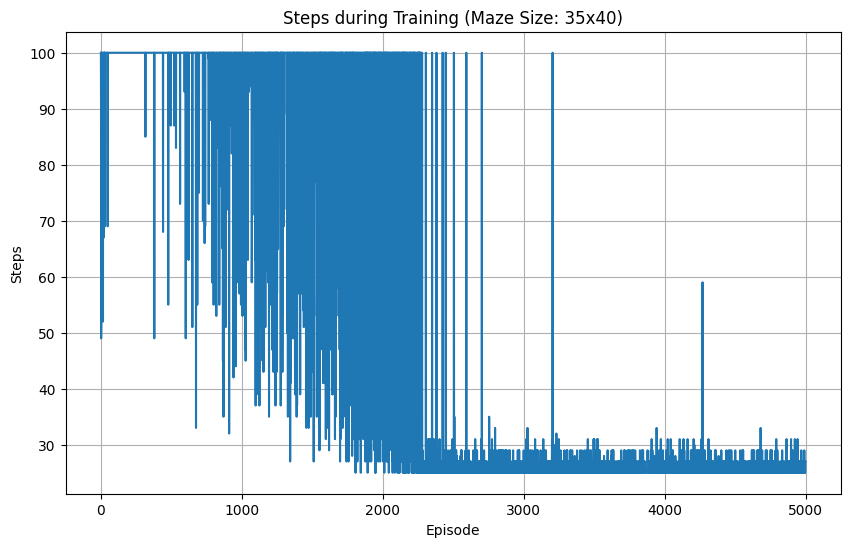

___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
____________________________

In [15]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Rewards']
print(x)
y = df['Test Result Steps']

# Create a scatter plot
plt.scatter(x, y)
plt.xlabel('Rewards')
plt.ylabel('Result Steps')
plt.title('Scatter Plot of Error vs Accuracy ')
plt.show()

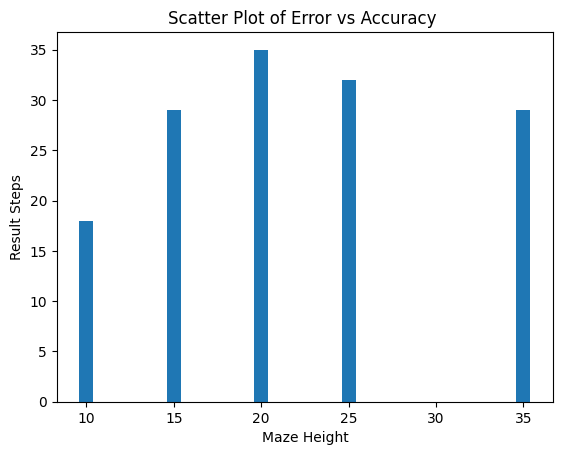

In [16]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Test Result Steps']
y = df['Result Steps']

# Create a scatter plot
plt.scatter(x, y)
plt.xlabel('Test Result Steps')
plt.ylabel('Result Steps')
plt.title('Scatter Plot of Error vs Accuracy ')
plt.show()

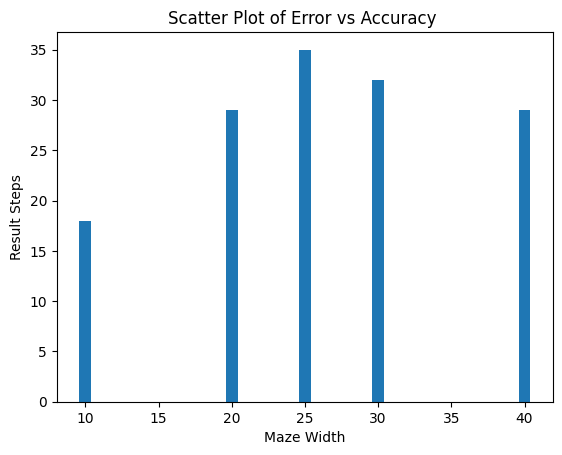

In [17]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Episodes']
y = df['Result Steps']

# Create a scatter plot
plt.scatter(x, y)
plt.xlabel('Episodes')
plt.ylabel('Result Steps')
plt.title('Scatter Plot of Error vs Accuracy ')
plt.show()

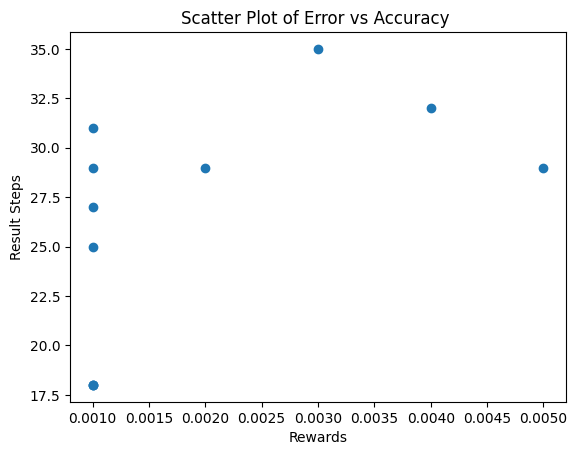

In [20]:
# Extract the 'Joint range X' and 'Joint range Y' columns
x = df['Decay(Learning Rate)']
y = df['Result Steps']

# Create a scatter plot
plt.scatter(x, y)
plt.xlabel('Decay(Learning Rate)')
plt.ylabel('Result Steps')
plt.title('Scatter Plot of Error vs Accuracy ')
plt.show()

In [41]:
import matplotlib.pyplot as plt

# Define maze parameters
maze_params = [[10, 10], [15, 20], [20, 25], [25, 30], [35, 40]]  # Update maze sizes
start_points = [[0, 0], [2, 4], [4, 8], [8, 16], [16, 32]]  # Update start positions

# Define epsilon values
epsilon_values = [
    {'start': 1, 'min': 0.01, 'decay': 0.001},
    {'start': 0.8, 'min': 0.05, 'decay': 0.002},
    {'start': 0.5, 'min': 0.1, 'decay': 0.003},
    {'start': 0.3, 'min': 0.2, 'decay': 0.004},
    {'start': 0.2, 'min': 0.04, 'decay': 0.005}
]

# Loop through maze parameters
for i in range(len(maze_params)):
    # Create maze environment
    maze_height, maze_width = maze_params[i]
    start = start_points[i]
    maze = grid_env(maze_height, maze_width, start)

    # Create agent
    epsilon = epsilon_values[i]
    #epsilon = {'start': 1, 'min': 0.01, 'decay': 0.001}  # Update epsilon values as needed
    learning_rate = 0.1  # Update learning rate as needed
    discount_factor = 0.9  # Update discount factor as needed
    ag = agent(maze.n_states, eps=epsilon, learning_rate=learning_rate,
               discount=discount_factor)  # Update agent parameters as needed

    # Train agent
    episodes = 5000
    steps = 100
    [rewards, steps] = ag.train(maze, episodes, steps)
    display_learning(rewards, "reward ")
    display_learning(steps, "steps ")

    print(ag.Q_table)

    # Plot rewards and steps
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards during Training (Maze Size: {}x{})'.format(maze_height, maze_width))
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(steps)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.title('Steps during Training (Maze Size: {}x{})'.format(maze_height, maze_width))
    plt.grid(True)
    plt.show()

    # Test agent
    maze = grid_env(maze_height, maze_width, start, debug=True)
    test_agent_steps = ag.test_agent(maze)
    print("Number of steps: ", test_agent_steps)
    df = update_dataframe(df, steps, test_agent_steps, rewards, episodes, maze_height, maze_width, epsilon['decay'], start)
